# Notebook to asses final model output against the unseen validation dataset

Provides metrics for the trained model. The final model in production is trained on the complete dataset.

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, recall_score, precision_score, brier_score_loss
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.pipeline import Pipeline

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced

from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, DiscriminationThreshold, ClassPredictionError, PrecisionRecallCurve
from yellowbrick.model_selection import CVScores

import matplotlib.pyplot as plt
import seaborn as sns



pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

### Load training and test dataset avaliable from https://zenodo.org/record/2586461#.XvwL8cgzZPY

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Protolith/classifier_data_2019-02-26_ilr_training.csv',encoding = "ISO-8859-1", engine='python') #training set
df_test = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Protolith/classifier_data_2019-02-26_ilr_validation.csv',encoding = "ISO-8859-1", engine='python') #validation set


In [ ]:
df_train.head(2)

,rock_group,rock_type,sample_id,author,title,journal,year,doi,bibtex,sio2,tio2,al2o3,feo_tot,mgo,cao,na2o,k2o,p2o5,index,coord_1,coord_2,coord_3,coord_4,coord_5,coord_6,coord_7,coord_8
0,igneous,granodiorite,16,BAS_GEOLDB,NaN,NaN,NaN,NaN,NaN,69.27551,0.408163,16.142857,1.846939,1.530612,3.948980,4.306122,2.438776,0.102041,16,3.630413,-0.906700,1.236365,1.125713,0.053931,-0.034578,0.501877,3.434975
1,igneous,granodiorite,60,Mikhalsky; E.V.; Kamenev; I.A.; 2013. Recurren...,NaN,NaN,NaN,NaN,NaN,63.98740,1.544558,15.110253,7.763439,2.469261,4.227213,2.276191,2.296515,0.325170,60,2.633229,-0.341836,0.335014,1.284073,0.557660,1.044427,0.896186,2.633364


### View numbers of the 2 classes. Dataset is dominated by igneous samples

In [ ]:
df_train['rock_group'].value_counts()

,count
rock_group,
igneous,447669
sedimentary,32355


In [ ]:
df_test['rock_group'].value_counts()

,count
rock_group,
igneous,49732
sedimentary,3604


### create X training set and binary labeled y array

In [ ]:

X_train, y_train = df_train[['sio2','tio2','al2o3','feo_tot','mgo','cao','na2o','k2o','p2o5']], df_train[['rock_group']].replace(['igneous','sedimentary'],[0,1])
X_test, y_test = df_test[['sio2','tio2','al2o3','feo_tot','mgo','cao','na2o','k2o','p2o5']], df_test[['rock_group']].replace(['igneous','sedimentary'],[0,1])

print('Training data')
print(X_train.shape)
print(y_train.shape)
print('\n')
print('Validation data')
print(X_test.shape)
print(y_test.shape)


Training data
(480024, 9)
(480024, 1)


Validation data
(53336, 9)
(53336, 1)


/tmp/ipython-input-3478356679.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train, y_train = df_train[['sio2','tio2','al2o3','feo_tot','mgo','cao','na2o','k2o','p2o5']], df_train[['rock_group']].replace(['igneous','sedimentary'],[0,1])
/tmp/ipython-input-3478356679.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test, y_test = df_test[['sio2','tio2','al2o3','feo_tot','mgo','cao','na2o','k2o','p2o5']], df_test[['rock_group']].replace(['igneous','sedimentary'],[0,1])


## Train selected model

Model selection was first done via testing multiple different classifiers using the pycaret, sklearn and imblearn libraries. The final classifer was then tuned via a GridSearchCV to get the best hyperparameters.
The model hyperparameters were then tweaked to reduce the final file size of the classfier down from 2.5Gb to ~100Mb. During this process the model scores (f1, precision and recall) and confusion matrix were monitored to ensure minimal reduction in the model performance.

In [ ]:
def train_model(X: pd.DataFrame, y: pd.DataFrame) -> Pipeline:
    """
    Function to train the protolith classification model.
    Paramaters:
        X: training data, default X_train
        y: training labels, default y_train
    returns
        trained model pipeline
    """
    # Create a pipeline to scale and train a calibrated balanced random forrest classifier
    cv = StratifiedKFold(n_splits=5, random_state=101, shuffle=True)

    clsf_pipe = Pipeline([('sc', StandardScaler()),
                ('classifier', CalibratedClassifierCV(estimator = BalancedRandomForestClassifier(n_estimators= 50, max_depth=15, min_samples_leaf= 1, min_samples_split= 2,
                max_features= 'sqrt',sampling_strategy='not minority', n_jobs= -1, random_state= 101), method= 'sigmoid', cv=cv))])
    # fit the model
    model_pipe = clsf_pipe.fit(X, y)

    return model_pipe

Model50_15_full = train_model(X_train, y_train)

Model50_15_full.steps

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

[('sc', StandardScaler()),
 ('classifier',
  CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
                         estimator=BalancedRandomForestClassifier(max_depth=15,
                                                                  n_estimators=50,
                                                                  n_jobs=-1,
                                                                  random_state=101,
                                                                  sampling_strategy='not '
                                                                                    'minority')))]

## Model scores for the trained model on the unseen test data

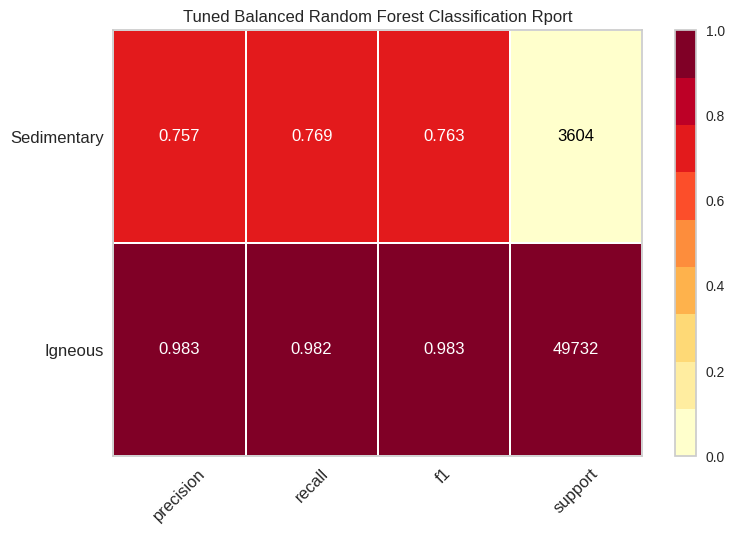

<Axes: title={'center': 'Tuned Balanced Random Forest Classification Rport'}>

In [ ]:
vis = ClassificationReport(Model50_15_full, classes=['Igneous','Sedimentary'],support=True, is_fitted=True, title='Tuned Balanced Random Forest Classification Rport')
vis.fit(X_train,y_train)
vis.score(X_test,y_test)
vis.show()

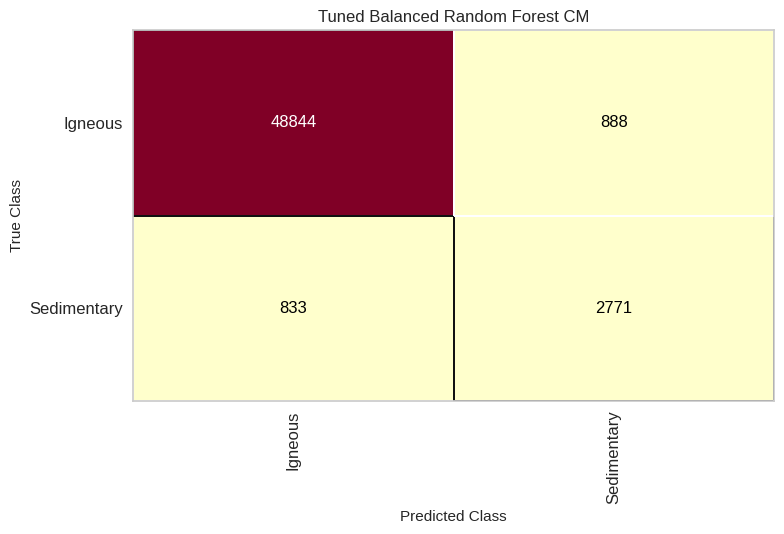

<Axes: title={'center': 'Tuned Balanced Random Forest CM'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
cm = ConfusionMatrix(Model50_15_full,classes=['Igneous','Sedimentary'],is_fitted=True, title='Tuned Balanced Random Forest CM')
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
cm.show()

/usr/local/lib/python3.12/dist-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


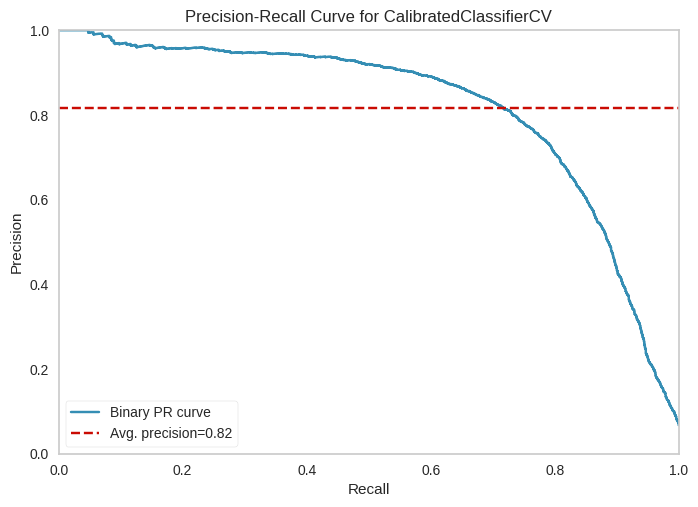

<Axes: title={'center': 'Precision-Recall Curve for CalibratedClassifierCV'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
pr = PrecisionRecallCurve(Model50_15_full,per_class= True, classes=['Igneous','Sedimentary'],is_fitted=True)
pr.fit(X_train,y_train)
pr.score(X_test,y_test)
pr.show()

### Predict values on test data and plot predictions agains the known lithological labels on the test data.

It's clear from this that the model predicts well for most rock types, except where there is significant overlap in compositions, such as
in wacke, dolomite, shale and arkose. Iron-rich shales are only at about 50% accuracy. Igneous rocks look much better, but they are significantly
more numerous in the dataset.


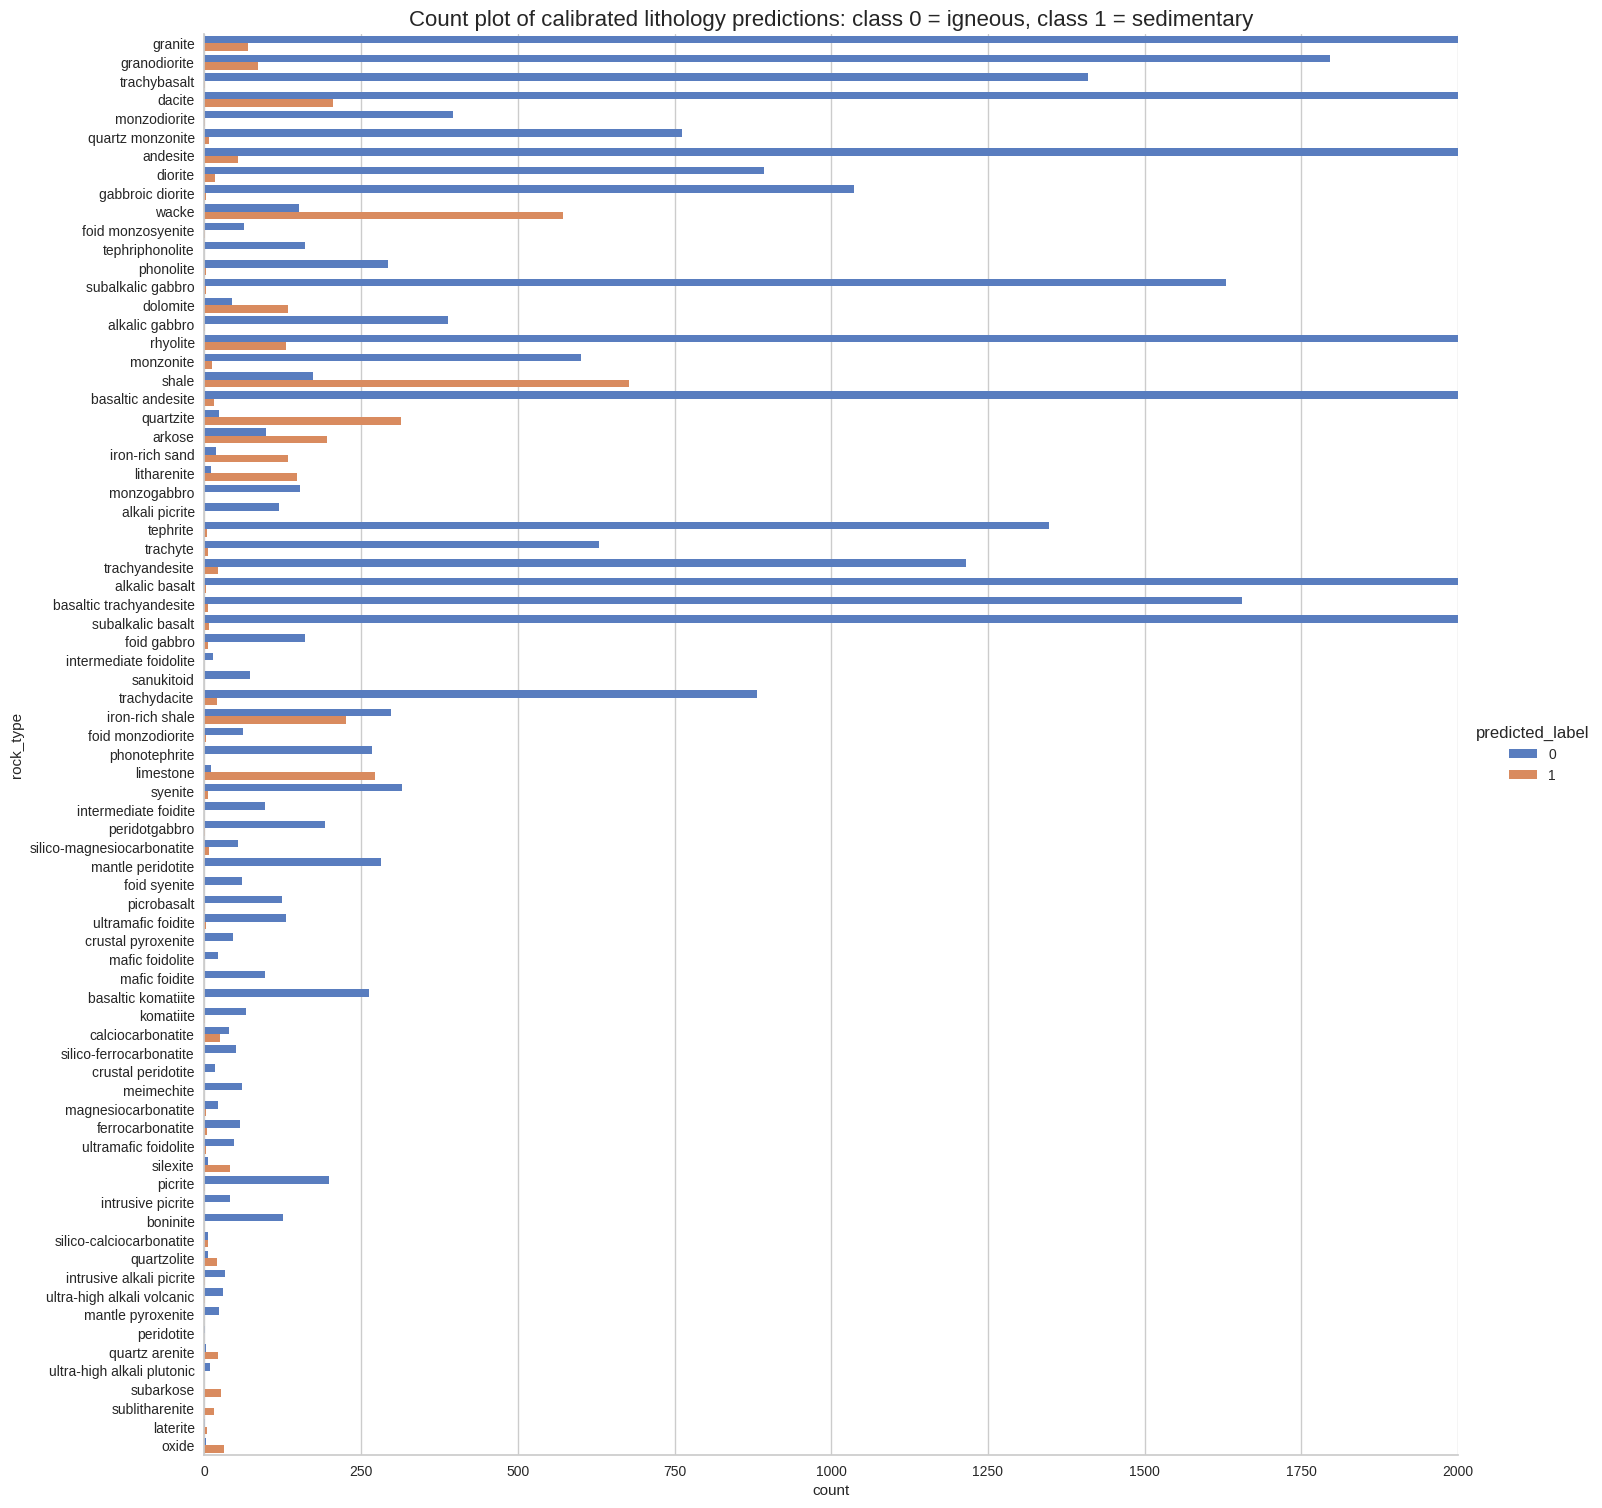

In [ ]:
test_predictions = pd.DataFrame(Model50_15_full.predict(X_test))
test_probability = pd.DataFrame(Model50_15_full.predict_proba(X_test))

validation_predictions = pd.concat([df_test[['rock_group','rock_type']],y_test, test_predictions, test_probability],axis=1)
validation_predictions.columns = ['rock_group', 'rock_type', 'true_label', 'predicted_label','proba_0', 'proba_1']

sns.catplot(hue='predicted_label',y= 'rock_type', data=validation_predictions, height = 15,kind='count',palette='muted')
plt.xlim(0,2000)
plt.title('Count plot of calibrated lithology predictions: class 0 = igneous, class 1 = sedimentary', fontsize=16)
plt.show()
